In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# import SimpleITK as sitk
import cv2
from sklearn import datasets,metrics,model_selection,preprocessing
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Subset
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Concatenate, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
import pickle
import warnings
warnings.filterwarnings('ignore')



---

## Import Data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/MIT Spring/Computer Vision Project/Data/20230429/20230429_processed_data_batch_0.pkl', 'rb') as fp:
    batch = pickle.load(fp)
adc = batch['adc'].values()
adc = np.array(list(adc))

cor = batch['cor'].values()
cor = np.array(list(cor))

hbv = batch['hbv'].values()
hbv = np.array(list(hbv))

sag = batch['sag'].values()
sag = np.array(list(sag))

t2w = batch['t2w'].values()
t2w = np.array(list(t2w))

In [ ]:
print(t2w.shape)

(300, 27, 64, 64)


In [ ]:
from tqdm import tqdm

In [ ]:
for i in tqdm(range(1,4)):
  with open(f'/content/drive/MyDrive/MIT Spring/Computer Vision Project/Data/20230429/20230429_processed_data_batch_{i}.pkl', 'rb') as fp:
    batch = pickle.load(fp)
    adc_data = batch['adc'].values()
    adc_data = np.array(list(adc_data))
    print(adc_data.shape)
    adc = np.concatenate([adc,adc_data], axis = 0)

    cor_data = batch['cor'].values()
    cor_data = np.array(list(cor_data))
    cor = np.concatenate([cor,cor_data], axis = 0)

    hbv_data = batch['hbv'].values()
    hbv_data = np.array(list(hbv_data))
    hbv = np.concatenate([hbv,hbv_data], axis = 0)

    sag_data = batch['sag'].values()
    sag_data = np.array(list(sag_data))
    sag = np.concatenate([sag,sag_data], axis = 0)

    t2w_data = batch['t2w'].values()
    t2w_data = np.array(list(t2w_data))
    print(t2w_data.shape)
    t2w = np.concatenate([t2w,t2w_data], axis = 0)

  0%|          | 0/3 [00:00<?, ?it/s]

(298, 27, 64, 64)
(298, 27, 64, 64)


 33%|███▎      | 1/3 [00:09<00:19,  9.88s/it]

(299, 27, 64, 64)
(299, 27, 64, 64)


 67%|██████▋   | 2/3 [00:20<00:10, 10.38s/it]

(302, 27, 64, 64)
(302, 27, 64, 64)


100%|██████████| 3/3 [00:33<00:00, 11.21s/it]


In [ ]:
print(adc.shape)
print(cor.shape)
print(hbv.shape)
print(sag.shape)
print(t2w.shape)


(1199, 27, 64, 64)
(1199, 25, 64, 64)
(1199, 27, 64, 64)
(1199, 31, 64, 64)
(1199, 27, 64, 64)


In [ ]:
batch_0 = pd.read_csv('/content/drive/MyDrive/MIT Spring/Computer Vision Project/Data/20230429/20230429_batch_0_label.csv')
batch_1 = pd.read_csv('/content/drive/MyDrive/MIT Spring/Computer Vision Project/Data/20230429/20230429_batch_1_label.csv')
batch_2 = pd.read_csv('/content/drive/MyDrive/MIT Spring/Computer Vision Project/Data/20230429/20230429_batch_2_label.csv')
batch_3 = pd.read_csv('/content/drive/MyDrive/MIT Spring/Computer Vision Project/Data/20230429/20230429_batch_3_label.csv')

In [ ]:
label_df = batch_0.append(batch_1).append(batch_2).append(batch_3)

In [ ]:
label_df['case_ISUP'].value_counts().reset_index()

,index,case_ISUP
0,0,684
1,2,184
2,1,180
3,3,75
4,5,44
5,4,32




---

## Mapping ISUP Grading to 0 or 1 (No Cancer v. Cancer)

In [ ]:
label = np.array(label_df['case_ISUP'].to_list())

In [ ]:
label_df['csISUP'] = (label_df['case_ISUP'] >=2).astype(int)

In [ ]:
label_df['csISUP'].value_counts()

0    864
1    335
Name: csISUP, dtype: int64

In [ ]:
cs_ISUP_label = np.array(label_df['csISUP'].to_list())

In [ ]:
cs_ISUP_label

array([0, 0, 0, ..., 0, 0, 1])



---

## Define Model and Fit the Model

In [ ]:
## set up input and output data
input_data = [
    adc,  # shape: (1199, 27, 64, 64)
    # cor,  # shape: (1199, 25, 64, 64)
    # hbv,  # shape: (1199, 27, 64, 64)
    # sag,  # shape: (1199, 31, 64, 64)
    t2w   # shape: (1199, 27, 64, 64)
]

y_train = label    # shape: (1199,)

In [ ]:
adc[:960,:,:,:].shape

(960, 27, 64, 64)

In [ ]:
input_data_train = [
    adc[:960,:,:,:],  # shape: (960, 27, 64, 64)
    # cor[:960,:,:,:],  # shape: (960, 25, 64, 64)
    # hbv[:960,:,:,:],  # shape: (960, 27, 64, 64)
    # sag[:960,:,:,:],  # shape: (960, 31, 64, 64)
    t2w[:960,:,:,:]   # shape: (960, 27, 64, 64)
]

y_train = label[:960]    # shape: (1199,)

input_data_val = [
    adc[960:,:,:,:],  
    # cor[960:,:,:,:],  
    # hbv[960:,:,:,:],  
    # sag[960:,:,:,:],  
    t2w[960:,:,:,:]  
]

y_val = label[960:]    

In [ ]:
y_val.shape

(239,)

#### Try Predicting Clinically Significant First

In [ ]:
from keras.layers import GlobalAveragePooling2D

In [ ]:
def create_conv_branch(input_shape, name):
    inputs = Input(input_shape, name=name + '_input')
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name=name + '_conv1')(inputs)
    x = MaxPooling2D((3, 3), name=name + '_maxpool1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name=name + '_conv2')(x)
    x = MaxPooling2D((3, 3), name=name + '_maxpool2')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name=name + '_conv1')(inputs)
    x = MaxPooling2D((3, 3), name=name + '_maxpool1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name=name + '_conv2')(x)
    x = MaxPooling2D((3, 3), name=name + '_maxpool2')(x)

    # x = Flatten(name=name + '_flatten')(x)
    # x = Dense(128, activation='relu')(x)          # reduce dimensional space for embedding

    x = GlobalAveragePooling2D()(x)

    return inputs, x

input_shapes = {
    'ADC': (27, 64, 64),
    'T2W': (27, 64, 64)
}

inputs, embeddings = [], []
for name, shape in input_shapes.items():
    input_layer, embedding = create_conv_branch(shape, name)
    inputs.append(input_layer)
    embeddings.append(embedding)

concatenated = Concatenate()(embeddings)
x = Dense(512, activation='relu')(concatenated)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ADC_input (InputLayer)         [(None, 27, 64, 64)  0           []                               
                                ]                                                                 
                                                                                                  
 T2W_input (InputLayer)         [(None, 27, 64, 64)  0           []                               
                                ]                                                                 
                                                                                                  
 ADC_conv1 (Conv2D)             (None, 27, 64, 16)   9232        ['ADC_input[0][0]']              
                                                                                              

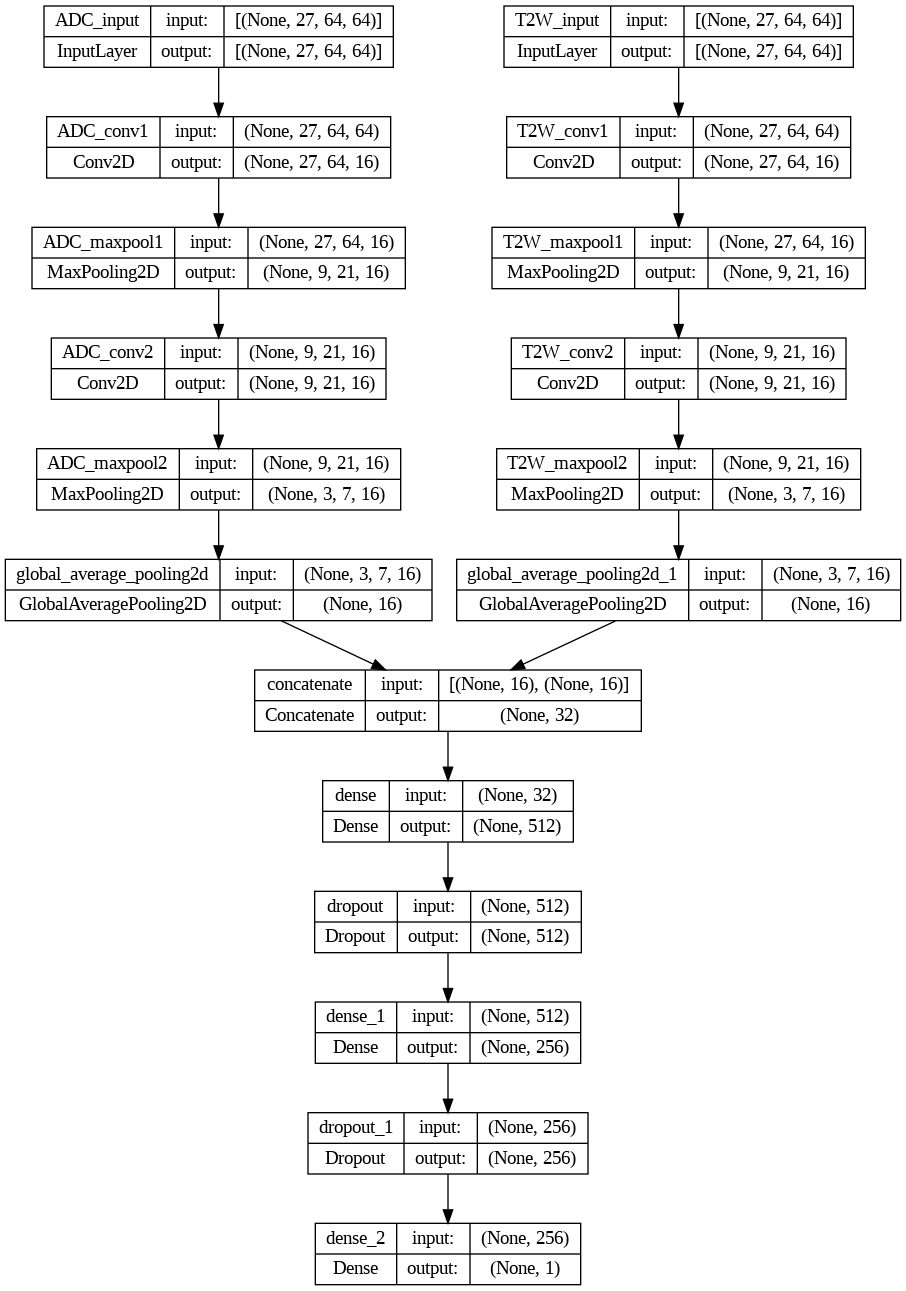

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
len(cs_ISUP_label)

1199

In [ ]:
len(y_train)

960

In [ ]:
cs_y_train = cs_ISUP_label[:960]

In [ ]:
cs_y_val = cs_ISUP_label[960:]

In [ ]:
len(cs_y_train)

960

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Metric to monitor
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)

In [ ]:
history = model.fit(input_data_train, cs_y_train, batch_size=64, epochs=30, validation_split=0.2,callbacks=[early_stopping])

Epoch 1/30
12/12 [==============================] - 4s 68ms/step - loss: 62.4345 - accuracy: 0.5820 - val_loss: 1.9549 - val_accuracy: 0.4427
Epoch 2/30
12/12 [==============================] - 0s 34ms/step - loss: 5.5943 - accuracy: 0.6016 - val_loss: 2.7958 - val_accuracy: 0.7448
Epoch 3/30
12/12 [==============================] - 0s 35ms/step - loss: 2.8289 - accuracy: 0.5938 - val_loss: 1.1066 - val_accuracy: 0.7135
Epoch 4/30
12/12 [==============================] - 0s 34ms/step - loss: 1.5858 - accuracy: 0.6016 - val_loss: 0.6930 - val_accuracy: 0.7396
Epoch 5/30
12/12 [==============================] - 0s 36ms/step - loss: 1.3617 - accuracy: 0.5781 - val_loss: 0.6750 - val_accuracy: 0.7448
Epoch 6/30
12/12 [==============================] - 0s 32ms/step - loss: 0.9792 - accuracy: 0.6146 - val_loss: 0.6529 - val_accuracy: 0.7448
Epoch 7/30
12/12 [==============================] - 0s 36ms/step - loss: 0.7539 - accuracy: 0.6654 - val_loss: 0.6491 - val_accuracy: 0.7448
Epoch 8/30
1

In [ ]:
len(cs_y_val)

239

In [ ]:
predict = model.predict(input_data_val)

8/8 [==============================] - 0s 11ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score


In [ ]:
def evaluate_thresholds(y_true, y_pred_probs, thresholds):
    results = []
    for threshold in thresholds:
        # Convert probabilities to binary predictions based on threshold
        y_pred = np.where(y_pred_probs >= threshold, 1, 0)
        
        # Calculate evaluation metrics
        positive_count = sum(y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        
        
        results.append((threshold, f1 , precision, recall, accuracy,positive_count))
    results_df = pd.DataFrame(results, columns=["Threshold","F1 Score" , "Precision", "Recall", "Accuracy","positive_count" ])
    return results_df

In [ ]:
evaluate_thresholds(cs_y_val, predict, np.arange(0, 1, 0.05))

,Threshold,F1 Score,Precision,Recall,Accuracy,positive_count
0,0.00,0.453074,0.292887,1.000000,0.292887,[239]
1,0.05,0.468227,0.305677,1.000000,0.334728,[229]
2,0.10,0.446809,0.297170,0.900000,0.347280,[212]
3,0.15,0.452107,0.308901,0.842857,0.401674,[191]
4,0.20,0.426778,0.301775,0.728571,0.426778,[169]
5,0.25,0.391960,0.302326,0.557143,0.493724,[129]
6,0.30,0.333333,0.278846,0.414286,0.514644,[104]
7,0.35,0.315068,0.302632,0.328571,0.581590,[76]
8,0.40,0.268908,0.326531,0.228571,0.635983,[49]
9,0.45,0.247423,0.444444,0.171429,0.694561,[27]


In [ ]:
df = pd.DataFrame({'Predictions': predict, 'Actuals': cs_y_val})
a=pd.crosstab(df.Predictions, df.Actuals)
a

In [ ]:
predict_adc_onlypredict_adc_only

In [ ]:
input_data_train = [
    adc[:960,:,:,:],  # shape: (960, 27, 64, 64)
    # cor[:960,:,:,:],  # shape: (960, 25, 64, 64)
    # hbv[:960,:,:,:],  # shape: (960, 27, 64, 64)
    # sag[:960,:,:,:],  # shape: (960, 31, 64, 64)
     #t2w[:960,:,:,:]   # shape: (960, 27, 64, 64)
]

# y_train = label[:960]    # shape: (1199,)

input_data_val = [
    adc[960:,:,:,:],  
    # cor[960:,:,:,:],  
    # hbv[960:,:,:,:],  
    # sag[960:,:,:,:],  
    # t2w[960:,:,:,:]  
]
def create_conv_branch(input_shape, name):
    inputs = Input(input_shape, name=name + '_input')
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name=name + '_conv1')(inputs)
    x = MaxPooling2D((3, 3), name=name + '_maxpool1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name=name + '_conv2')(x)
    x = MaxPooling2D((3, 3), name=name + '_maxpool2')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name=name + '_conv1')(inputs)
    x = MaxPooling2D((3, 3), name=name + '_maxpool1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name=name + '_conv2')(x)
    x = MaxPooling2D((3, 3), name=name + '_maxpool2')(x)

    # x = Flatten(name=name + '_flatten')(x)
    # x = Dense(128, activation='relu')(x)          # reduce dimensional space for embedding

    x = GlobalAveragePooling2D()(x)

    return inputs, x

input_shapes = {
    'ADC': (27, 64, 64)
    #'T2W': (27, 64, 64)
}

inputs, embeddings = [], []
for name, shape in input_shapes.items():
    input_layer, embedding = create_conv_branch(shape, name)
    inputs.append(input_layer)
    embeddings.append(embedding)

concatenated = Concatenate()(embeddings)
x = Dense(512, activation='relu')(concatenated)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

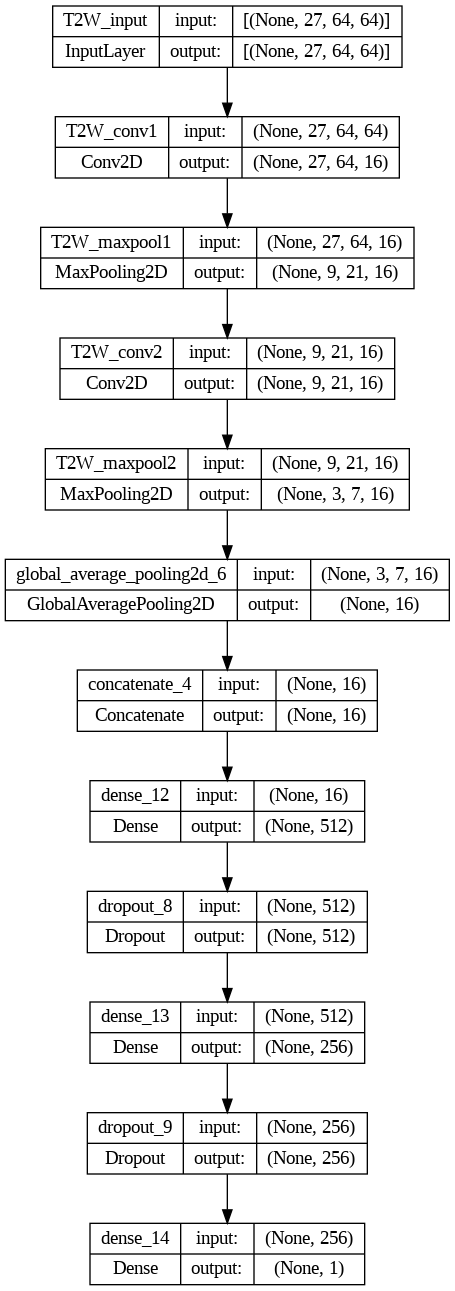

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(input_data_train, cs_y_train, batch_size=64, epochs=30, validation_split=0.2)

Epoch 1/30
12/12 [==============================] - 3s 51ms/step - loss: 32.5010 - accuracy: 0.5924 - val_loss: 3.6800 - val_accuracy: 0.5885
Epoch 2/30
12/12 [==============================] - 0s 20ms/step - loss: 8.1288 - accuracy: 0.6224 - val_loss: 4.5434 - val_accuracy: 0.6250
Epoch 3/30
12/12 [==============================] - 0s 20ms/step - loss: 4.5179 - accuracy: 0.5768 - val_loss: 1.7056 - val_accuracy: 0.7188
Epoch 4/30
12/12 [==============================] - 0s 22ms/step - loss: 2.7667 - accuracy: 0.6107 - val_loss: 1.0413 - val_accuracy: 0.7448
Epoch 5/30
12/12 [==============================] - 0s 21ms/step - loss: 1.5662 - accuracy: 0.6133 - val_loss: 0.7685 - val_accuracy: 0.6406
Epoch 6/30
12/12 [==============================] - 0s 21ms/step - loss: 1.2385 - accuracy: 0.6198 - val_loss: 0.6646 - val_accuracy: 0.6510
Epoch 7/30
12/12 [==============================] - 0s 22ms/step - loss: 0.9870 - accuracy: 0.6380 - val_loss: 0.6361 - val_accuracy: 0.7448
Epoch 8/30
1

In [ ]:
predict_adc_only = model.predict(input_data_val)

8/8 [==============================] - 0s 7ms/step


In [ ]:
evaluate_thresholds(cs_y_val, predict_adc_only, np.arange(0, 1, 0.05))

,Threshold,F1 Score,Precision,Recall,Accuracy,positive_count
0,0.00,0.453074,0.292887,1.000000,0.292887,[239]
1,0.05,0.448980,0.294643,0.942857,0.322176,[224]
2,0.10,0.427046,0.284360,0.857143,0.326360,[211]
3,0.15,0.426357,0.292553,0.785714,0.380753,[188]
4,0.20,0.447257,0.317365,0.757143,0.451883,[167]
5,0.25,0.403941,0.308271,0.585714,0.493724,[133]
6,0.30,0.354286,0.295238,0.442857,0.527197,[105]
7,0.35,0.250000,0.243243,0.257143,0.548117,[74]
8,0.40,0.253968,0.285714,0.228571,0.606695,[56]
9,0.45,0.190476,0.285714,0.142857,0.644351,[35]


In [ ]:
input_data_train = [
    #adc[:960,:,:,:],  # shape: (960, 27, 64, 64)
    # cor[:960,:,:,:],  # shape: (960, 25, 64, 64)
    # hbv[:960,:,:,:],  # shape: (960, 27, 64, 64)
    # sag[:960,:,:,:],  # shape: (960, 31, 64, 64)
     t2w[:960,:,:,:]   # shape: (960, 27, 64, 64)
]

# y_train = label[:960]    # shape: (1199,)

input_data_val = [
    adc[960:,:,:,:],  
    # cor[960:,:,:,:],  
    # hbv[960:,:,:,:],  
    # sag[960:,:,:,:],  
    t2w[960:,:,:,:]  
]